# Use of neural networks for inversion of seismic data

Gunter Roethe and Albert Tarantola (1991) Use of neural networks for inversion of seismic data. SEG Technical Program Expanded Abstracts 1991: pp. 302-305.
https://doi.org/10.1190/1.1888938 

In [48]:
%matplotlib inline
import numpy as np
import pylab as plt
import bruges

from fatiando.seismic import conv
from fatiando.vis import mpl

/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [364]:
models = []
vps = []
rcs = []
synths = []

num_models = 14
num_layers = 3
num_depth = 60
layer_points = int(num_depth / num_layers)
layer_thickness = 200 # meters
dz = layer_thickness/layer_points
depths = np.linspace(0, 600, 60)

for i in np.arange(num_models):
    model = np.zeros(num_layers)
    vp = np.zeros((num_depth,1))
    vs = np.ones((num_depth,1))
    rho = np.ones((num_depth,1))
    # first layer velocity
    perturb = np.random.randint(-100, 100)
    layer_vp = 1200 + perturb
    model[0] = layer_vp
    vp[:layer_points] = layer_vp
    
    

    
    for l in np.arange(1,num_layers):
        perturb = np.random.randint(-100, 100)
        layer_vp = (model[l-1] + 450) + perturb
        model[l] = layer_vp
        start_ind = int(l * layer_points)
        end_ind = int((l+1) * layer_points)
        #print('start: {}, end: {}'.format(start_ind, end_ind))
        vp[start_ind:end_ind] = layer_vp        
        
    
    rcb = bruges.reflection.reflectivity(vp, vs, rho, theta=[0])
    vel_l = conv.depth_2_time(vp, vp, dt=6e-3, dz=dz)
    rho_l = 2200*np.ones(np.shape(vel_l))
    rc = conv.reflectivity(vel_l, rho_l)
    synt = conv.convolutional_model(rc, 30, conv.rickerwave, dt=2e-3)
    
    models.append(model)
    vps.append(vp)
    rcs.append(rcb)
    synths.append(synt)

/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/fatiando/seismic/conv.py:139: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  TWT_rs = np.zeros(np.ceil(TMAX/dt_dwn))
/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/fatiando/seismic/conv.py:164: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  vel[kk:lim, j] = tck(TWT_rs[kk:lim])
/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/fatiando/seismic/conv.py:166: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  vel[lim:, j] = vel[lim-1, j]
/Users/bhall/.edm/envs/dee

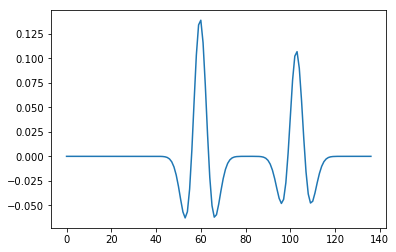

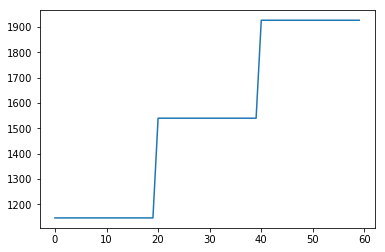

In [352]:
plt.plot(synt)
plt.figure()
plt.plot(vp)

The output of the NN are layer velocities.  So the model is the output.  The input are the synthetic seismograms associated with them.

In [353]:
y = np.array(vps)[:,:,0] # normalize model velocities
max_vel = np.max(y)
y /= max_vel
max_vel

2203.0

In [354]:
# pad each seismogram with zeros so they are the same length
max_size = int(np.max([el.shape[0] for el in synths]))
cleaned_synths = []
for s in synths:
    pad_width = max_size - int(s.shape[0])
    s = np.pad(s, pad_width=((0,pad_width),(0,0)), mode='constant', constant_values=[0])
    cleaned_synths.append(s)

In [355]:
X = np.array(cleaned_synths)[:,:,0]

In [356]:
X.shape

(14, 138)

In [357]:
from sklearn.neural_network import MLPRegressor

In [358]:
nn = MLPRegressor(hidden_layer_sizes=(5, ), verbose=True, max_iter=10000, tol=1e-6)
nn.fit(X,y)
y_pred = nn.predict(X)


Iteration 1, loss = 0.32635958
Iteration 2, loss = 0.32529561
Iteration 3, loss = 0.32424916
Iteration 4, loss = 0.32321883
Iteration 5, loss = 0.32220694
Iteration 6, loss = 0.32121111
Iteration 7, loss = 0.32023263
Iteration 8, loss = 0.31926777
Iteration 9, loss = 0.31831894
Iteration 10, loss = 0.31738227
Iteration 11, loss = 0.31645704
Iteration 12, loss = 0.31554694
Iteration 13, loss = 0.31465228
Iteration 14, loss = 0.31377466
Iteration 15, loss = 0.31290848
Iteration 16, loss = 0.31205421
Iteration 17, loss = 0.31120836
Iteration 18, loss = 0.31037134
Iteration 19, loss = 0.30954380
Iteration 20, loss = 0.30872373
Iteration 21, loss = 0.30791538
Iteration 22, loss = 0.30711581
Iteration 23, loss = 0.30632490
Iteration 24, loss = 0.30554082
Iteration 25, loss = 0.30476177
Iteration 26, loss = 0.30398746
Iteration 27, loss = 0.30321882
Iteration 28, loss = 0.30245519
Iteration 29, loss = 0.30169584
Iteration 30, loss = 0.30094053
Iteration 31, loss = 0.30018929
Iteration 32, los

In [359]:
# def get_curve_from_model(model, num_layers, num_points):
    
#     curve = np.ones((num_points))
#     layer_points = num_points / num_layers
#     for i in np.arange(num_layers):
#         start_ind = int(i * layer_points)
#         end_ind = int((i+1) * layer_points)
#         curve[start_ind:end_ind] *= model[i]
    
#     return curve
    

In [360]:
# mod_pred = get_curve_from_model(y_pred[0], 3, 60)
# mod = get_curve_from_model(y[0], 3, 60)

### Roethe and Tarantola (1991) Figure 7


2 of 14 examples of the models (bottom) and seismograms(top) used to train the neural network. The desired or “true” model is shown by a blue line, the prediction is orange.

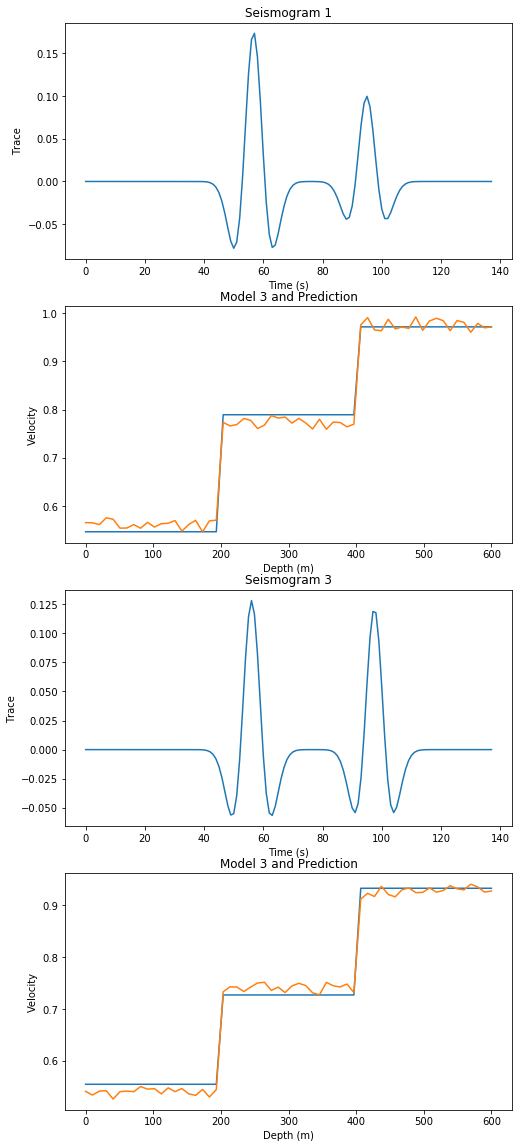

In [361]:
fig, ax = plt.subplots(4,1, figsize=(8,20))

ax[0].plot(cleaned_synths[0])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Trace')
ax[0].set_title('Seismogram 1')

ax[1].plot(depths, y[0])
ax[1].plot(depths, y_pred[0])
ax[1].set_xlabel('Depth (m)')
ax[1].set_ylabel('Velocity')
ax[1].set_title('Model 3 and Prediction')

ax[2].set_title('Seismogram 3')
ax[2].plot(cleaned_synths[3])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Trace')

ax[3].set_title('Model 3 and Prediction')
ax[3].plot(depths, y[3])
ax[3].plot(depths, y_pred[3])
ax[3].set_xlabel('Depth (m)')
ax[3].set_ylabel('Velocity')

### Roethe and Tarantola (1991) Figure 8


Decrease of the loss function for the network trained with the seismograms. The final loss value is about 0.0011.

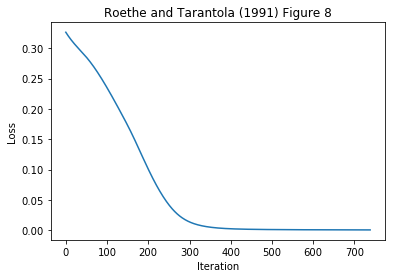

In [362]:
from sklearn.model_selection import learning_curve
loss_values = nn.loss_curve_
plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Roethe and Tarantola (1991) Figure 8')